# Stéréovision

![Suzanne](main.png)

La stéréovision est une discipline qui s’occupe de reconstruire des informations 3D à partir d’images. Ppour que la reconstruction d’un point soit possible, il faut plusieurs images de ce point. Ces images doivent être prises de points de vue différents. L’étape clé de la reconstruction, qui pose souvent problème, est d’indentifier l’image du point à reconstruire dans chacune des vues.

## Géométrie épipolaire

La géométrie épipolaire fait intervenir deux caméras. La géométrie épipolaire décrit les propriétés géométriques entre deux vues d’une même scène et ne dépend que des paramètres intrinsèques des caméras et de leurs positions relatives. Elle fournit, en particulier, la contrainte épipolaire, qui nous sera très utile pour produire les appariements entre vues.

## La matrice fondamentale

![Géométrie épipolaire - Sanyam Kapoor](https://i.imgur.com/GbafZIY.png)

Imaginons que nous ayons deux images, droite et gauche, de l’espace monde. Prenons un point $\vec{x}$ dans l’espace image droit. Le point $\vec{X}$ de l’espace monde, dont $\vec{x}$ est l’image, peut se trouver n’importe où sur la droite passant par $\vec{x}$ et le centre optique de la caméra de droite. Nous appellerons cette droite, le rayon retro-projeté de $\vec{x}$. Notons $\vec{x}'$ l’image de $\vec{X}$ dans l’espace image gauche. Le lieu de $\vec{x}'$ est donc la droite image du rayon retro-projeté de $\vec{x}$. Cette droite est appelée ligne épipolaire et notée $\vec{l}'$. La ligne épipolaire passe par l’épipole $\vec{e}'$, image du centre optique de la caméra de droite.

En géométrie projective 2D, une droite d’équation $ax+by+c = 0$ est représentée par un vecteur à trois composantes $(a, b, c)^T$ définies à un facteur près. On a donc la relation suivante:

>Le point $\vec{x}$ appartient à la droite $\vec{l}$ si et seulement si $x^T\vec{l} = 0$.

De plus, en géométrie projective 2D, les relations remarquables suivantes sont valables:

- L’intersection de deux lignes $l$ et $l'$ est donnée par $x = l \times l'$,
- La droite passant par deux points $x$ et $x'$ est donnée par $l = x \times x'$.

Notons que le produit vectoriel peut être écrit comme un produit de matrice $x \times y = [x]_\times y$ où

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

Pour trouver l’équation de la ligne épipolaire dans l’espace image gauche, il nous suffit donc de trouver les coordonnées de deux points de cette ligne. Le premier est l’image $P'\vec{C}$ du centre optique $\vec{C}$ de la caméra de droite où $P'$ est la matrice de projection de la caméra de gauche. Le deuxième est $P'P^{+}\vec{x}$ où $P^{+}$ est la pseudo inverse de la matrice de projection $P$ de la caméra de droite. La ligne épipolaire a donc pour équation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ avec $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ est appelée matrice fondamentale.

Comme la ligne épipolaire $\vec{l}' = F\vec{x}$ est le lieu de $\vec{x}'$, $\vec{x}'$ appartient donc à $\vec{l}'$ ce qui conduit à la contrainte épipolaire :

>**La matrice fondamentale est telle que pour toute paire de points se correspondant $\vec{x} \leftrightarrow \vec{x}'$ dans les deux images, on a $\vec{x}'^{T}F\vec{x} = 0$.**

## Calcul de la matrice fondamentale

La matrice fondamentale $F$ a sept degrés de liberté. Elle possède neuf composantes mais celles-ci sont définies à un facteur d’échelle près, ce qui enlève un degré de liberté. De plus, la matrice $F$ est une matrice singulière ($det(F) = 0$) ce qui nous fait bien sept degrés de liberté. Il nous faut donc sept correspondances minimum pour calculer $F$. L’équation $x'^{T}_iFx_i = 0$ et les sept correspondances nous permettent d’écrire un système d’équations de la forme $Af = 0$, où $f$ est le vecteur qui contient les composantes de la matrice $F$. Admettons que $A$ soit une matrice 7×9 de rang 7. La solution générale de $Af = 0$ peut s’écrire $\alpha f_1 + (1−\alpha) f_2$ où $f_1$ et $f_2$ sont deux solutions particulières indépendantes de $Af = 0$. On utilise ensuite la contrainte de singularité $det(\alpha F_1 + (1 − \alpha)F_2) = 0$ pour déterminer $\alpha$. La contrainte de singularité donnant lieu à une équation du troisième degré, on pourra avoir une ou trois solutions pour $F$.

## OpenCV

En pratique vous allez utiliser la bibliothèque OpenCV. En python, vous avez accès à ses fonctions grâce au module `cv2`.

Vous pouvez trouver de l'aide concernant les fonctions de calibration et de reconstruction à la page https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

## Objectif

Dans le zip de l'énoncé vous trouverez deux séquences d'images prise par deux caméras pendant le balayage d'un objet par un plan laser.

![Laser](scanRight/scan0010.png)

Vous trouverez également des prises de vue d'un damier dans différentes position qui vous aideront à calibrer vos caméras.

![Damier](checkboards/c2Right.png)

Le but est de reconstruire en 3D l'objet scanné.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# object points (3D points of corners in chessboard)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('chessboards/*.png')

""" Get info camera position by detecting chessboard corners and 
    draw corner lines 
    -> get intrinsic parameters of camera (because camera is calibrated)"""
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
   
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,7), flags = cv.CALIB_CB_ADAPTIVE_THRESH | cv.CALIB_CB_NORMALIZE_IMAGE)
    
    # If found, add object points, image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,7), corners2, ret)
        plt.imshow(img)
        plt.show()
    
    # this function returns 
    #  - the result
    #  - camera matrix
    #  - distortion coefficients
    #  - rotation and translation vectors
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None)

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
""" draws 3D axes on chessboards from corners in the chessboard 
    (obtained using cv.findChessboardCorners()) and axis points"""
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

In [3]:
""" Axis points are points in 3D space for drawing the axis. We draw axis
    of length 3 (units will be in terms of chess square size since 
    we calibrated based on that size). So our X axis is drawn 
    from (0,0,0) to (3,0,0), so for Y axis. For Z axis, it is drawn 
    from (0,0,0) to (0,0,-3)."""
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

chessboards\c4Left.png
chessboards\c4Right.png


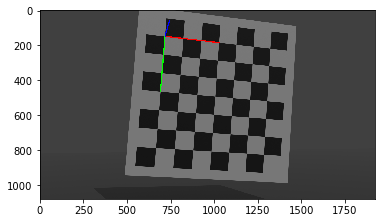

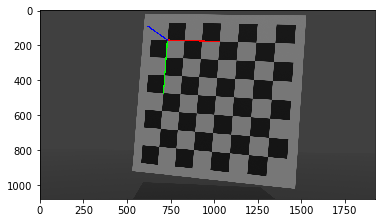

In [4]:
""" just to show axes on chessboard
    NOT important for generation"""
for fname in glob.glob('chessboards/c4*.png'):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None)
    if ret:
        print(fname)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        
        # Find the rotation and translation vectors.
        ret,pnprvecs, pnptvecs = cv.solvePnP(objp, corners2, mtx, dist)
        
        # project 3D points to image plane
        imgpts, jac = cv.projectPoints(axis, pnprvecs, pnptvecs, mtx, dist)
        img = draw(img,corners2,imgpts)
        plt.imshow(img)
        plt.show()
    

In [5]:
""" Rotation matrix for each camera from the rotation vector"""
rmatRight = cv.Rodrigues(rvecs[0])[0]
rmatLeft = cv.Rodrigues(rvecs[4])[0]

""" Translation matrix for each camera from rotation matrix and the translation vector"""
rotMatRight = np.concatenate((rmatRight,tvecs[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft,tvecs[4]), axis=1)

""" Matrix projections from camera matrix and rotation matrix"""
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

""" Matrix for center of pro """ 
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])


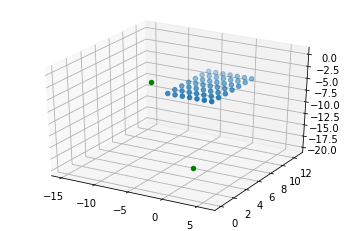

In [6]:
%matplotlib inline
""" show positions of cameras for verification 
    NOT important for generation"""
def plotDotWorld():
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    ax.scatter3D(objp[:,0],objp[:,1],objp[:,2])
    
    x,y,z,d = camWorldCenterLeft
    ax.scatter(x, y, z, c='g', marker='o')
    
    x2,y2,z2,d2 = camWorldCenterRight
    ax.scatter(x2, y2, z2 , c='g', marker='o')
    
    plt.show()
    
plotDotWorld()

In [7]:
""" Calculation of the fundamental matrix to find epipoles and epilines"""

# [P'C→]x where P'C is the epipole of the second image
def crossMat(v):
    v = v[:,0]
    return np.array([ [ 0,-v[2],v[1] ],[ v[2],0,-v[0] ],[ -v[1],v[0],0 ] ])

""" 
    Equation : F=[P′C→]× P′ P+
    
    ->  contains info about translation and rotation, which describes the position
        of the 2nd camera relative to the 1st camera in global coordinates
"""
def matFondamental(camLeft,centerRight,camRight):
        return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight))

""" Pixel mask that contains all the degrees of red """
def getRed(fname):
    img = cv.imread(fname)
    red = img[:,:,2]
    # https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    ret, mask = cv.threshold(red,127,255,cv.THRESH_TOZERO)
    return mask

""" 
    result : epiline
    from : fundamental matrix and x
        x : image point of the point X in the world
"""
def getEpiLines(F, points):
    return F @ points

""" 
    find all points where the laser is, thus red
"""
def getReddAvg(fname):
    red = getRed(fname)
    redPoints = [[],[],[]]

    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints

""" 
    find all the epilines from the image scans 
    -> thus the epilines of the right image corresponding to the left points
"""
def findEpilines(path):
    epilines = []
    
    for l in range(26):
        # for sorting (really important for next
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        redPoints = getReddAvg(strp)
        tempEpilines = []
        
        # Get all epilines of the right image that correspond to the left points 
        epilinesRight = getEpiLines(Fondamental, redPoints)
        tempEpilines.append(redPoints)
        tempEpilines.append(epilinesRight)
        epilines.append(tempEpilines)
    return epilines


Fondamental = matFondamental(camRight,camWorldCenterLeft,camLeft)
# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
epl = findEpilines('scanLeft/')

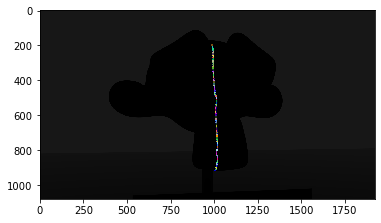

[-2.52220612e+04 -2.78599348e+04  2.93676316e+07]
[-2.54510384e+04 -2.75425971e+04  3.07043706e+07]
[-2.56309583e+04 -2.72199956e+04  3.18921808e+07]
[-2.58123542e+04 -2.68975524e+04  3.30844717e+07]
[-2.59983115e+04 -2.65755987e+04  3.42906102e+07]
[-2.61952198e+04 -2.62548200e+04  3.55299939e+07]
[-2.63989736e+04 -2.59347758e+04  3.67901596e+07]
[-2.65943453e+04 -2.56138323e+04  3.80248782e+07]
[-2.68371425e+04 -2.52979774e+04  3.94035726e+07]
[-2.69825949e+04 -2.49716775e+04  4.04867454e+07]
[-2.71712827e+04 -2.46500168e+04  4.17011734e+07]
[-2.73676124e+04 -2.43291760e+04  4.29388007e+07]
[-2.75618126e+04 -2.40081067e+04  4.41699629e+07]
[-2.77553059e+04 -2.36869616e+04  4.53989795e+07]
[-2.79486041e+04 -2.33657956e+04  4.66274037e+07]
[-2.81181181e+04 -2.30420775e+04  4.77836232e+07]
[-2.83147234e+04 -2.27212663e+04  4.90220872e+07]
[-2.84759865e+04 -2.23966629e+04  5.01532584e+07]


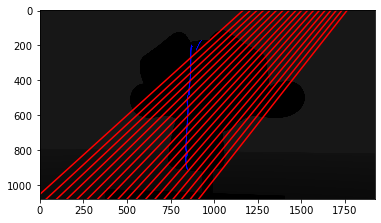

In [8]:
""" 
    For verification purposes (visual) 
    only lineY is used after 
"""

# first image with multicolor line to verify it takes the needed points 
# thus the points corresponding to laser scans 
def drawAvgPoint(fname,EplLeft):
    img = cv.imread(fname)
    i = 0
    while i< len(EplLeft[0]):
        color = tuple(np.random.randint(0,255,3).tolist())
        img = cv.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),5,color,-1)
        i += 10
    plt.imshow(img)
    plt.show()

""" 
    equation of epipolar line 
    ax + by + c = 0
    -> find y for x
"""
def lineY(coef,x):
    a,b,c = coef
    return-(c+a*x)/b

# draw epilines for verification 
def drawEpl(fname,EplRight):
    img = cv.imread(fname)
    coef , length = EplRight.shape
    for i in range(0,length,40):
        print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'r')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0013.png',epl[13][0])
drawEpl('scanRight/scan0013.png',epl[13][1])


In [9]:
""" Find the right points on the right scans with the corresponding epilines """
def eplRedPoints(path, EplRight):
    points = []
    for l in range(26):
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
        
        # corresponding to the right points
        redPoints = getReddAvg(strp)
        scan = cv.imread(strp)

        pointsRight = [[],[],[]]
        # epl = [[points][epilines]]
        eplImg = EplRight[l][1]
        print(strp)
        
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i])
                # find y coordinate for corresponding x by using
                # equation of epipolar line 
                # eplImg is a 3 times x array 
                y = int(lineY(eplImg[:,i],x))
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
                
                color = tuple(np.random.randint(0,255,3).tolist())
                scan = cv.circle(scan,(x,y),5,color,-1)
            except:
                pass
        points.append(pointsRight)
        # plt.imshow(scan)
        # plt.show()
    return points


pointsRight = eplRedPoints('scanRight/scan',epl)

scanRight/scan0000.png
scanRight/scan0001.png
scanRight/scan0002.png
scanRight/scan0003.png
scanRight/scan0004.png
scanRight/scan0005.png
scanRight/scan0006.png
scanRight/scan0007.png
scanRight/scan0008.png
scanRight/scan0009.png
scanRight/scan0010.png
scanRight/scan0011.png
scanRight/scan0012.png
scanRight/scan0013.png
scanRight/scan0014.png
scanRight/scan0015.png
scanRight/scan0016.png
scanRight/scan0017.png
scanRight/scan0018.png
scanRight/scan0019.png
scanRight/scan0020.png
scanRight/scan0021.png
scanRight/scan0022.png
scanRight/scan0023.png
scanRight/scan0024.png
scanRight/scan0025.png


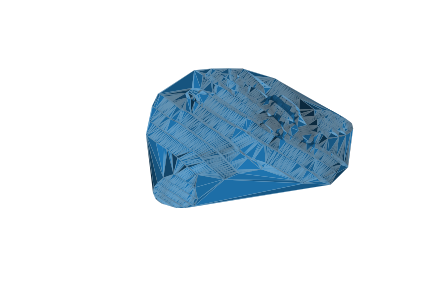

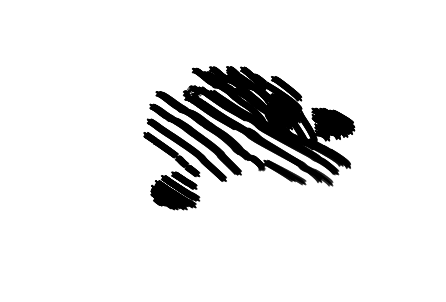

In [10]:
%matplotlib inline
from mathutils import geometry as pygeo
from mathutils import Vector
import json

""" 
    When we apply the pseudo invers camera matrix (pseudo inverse de la matrice camera )
    to the redpoint (point 2D), we obtain the real point (in 3D)
    However, pixels are not precise enough, thus we need to find actual point by 
    finding the calculating the intersection of those 2 points 
    And this by taking the lines connecting C and the point and then calculating 
    intersections between those 2 lines
"""

# converting to vector for mathutils
def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))

""" 
    intersection between the two reel points
    corresponding to actual points of the object
"""
def getIntersection(pointsLeft,pointsRight):
    
    # numpy array
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    # transpose 
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # calculation of the real point by applying the pseudo invers of 
    # the camera matrix to the given point
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # conversion of the 4 calculated array so it compatible with 
    # mathutils intersection method
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # display of the lines connecting center to object point
    '''
    draw3DLine(camCenterLeft,leftObject)
    draw3DLine(camCenterRight,rightObject)
    plt.show()
    '''

    # returns array of intersection points 
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)

# usefull for debugging  
def draw3DLine(start,end):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start,y_start,z_start = start
    x_end,y_end,z_end = end

    print("start = ({},{},{})".format(x_start,y_start,z_start))
    print("end = ({},{},{})\n".format(x_end,y_end,z_end))

    ax.scatter(x_start,y_start,z_start,c='r',marker='o')
    ax.plot([x_start ,x_end],[y_start,y_end],[z_start,z_end])

""" For each point, get the actual object point """
def getObjectPoint():
    point = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calculation of intersection point (array of vectors)
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                # print(intersection)
                for inter in intersection:
                    inter *= 1000 # scale
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass
    return np.array(point)
        
# display of point objects
def drawPointObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.scatter3D(point[0,:],point[1,:],point[2,:],c='black',marker='x')     
        
    ax.view_init(-95,-50)
    plt.axis('off')
    plt.show()
    

def drawSurfaceObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(point[0,:],point[1,:],point[2,:])     

    ax.view_init(-95,-50)
    plt.axis('off')
    plt.show()
    
    
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point.txt','+w') as file:
        json.dump(data,file)


point = getObjectPoint()
drawSurfaceObject(point)
drawPointObject(point)
pointToJson(point)